
# Data Processing Example - TRKR

In [52]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import experimentdataanalysis.analysis.dataframe_plotting as dfplot
import experimentdataanalysis.data_io.csv_to_dataframe as csv2df

In [53]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=6., y=6.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


## Load data

Run IDs found: [9, 10, 11, 12, 13, 14, 15]


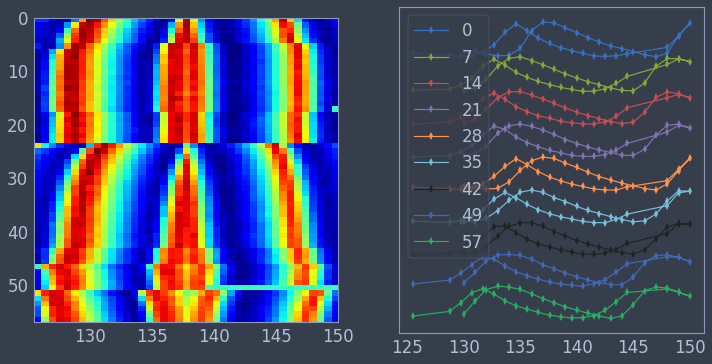

scancoord  kerr_rotation scan_type_2d scan_type_1d  \
run_id index_2d index_1d                                                       
9      1.0      0             130.0       -0.02180      voltage   b_external   
                1             131.0       -0.02170      voltage   b_external   
                2             132.0       -0.02855      voltage   b_external   
                3             133.0       -0.03275      voltage   b_external   
                4             134.0       -0.03225      voltage   b_external   

                              lockin2x      lockin2r  lockin1r  voltage  \
run_id index_2d index_1d                                                  
9      1.0      0         1.106644e-02  1.112800e-33   0.02220      0.0   
                1         1.055400e-03  1.100774e-32   0.02185      0.0   
                2         1.128660e-02  1.199200e-03   0.02870      0.0   
                3         1.288000e-33  1.227740e-03   0.03285      0.0   
                4         1.100820e-32  1.133100e-32   0.03225      0.0   

                          laserpower  cwetalon       laser_h  laser_v  \
run_id index_2d index_1d                                                
9      1.0      0              0.757    -0.145  3.940000e-11   0.0020   
                1              0.759    -0.152  3.100000e-22  -0.9559   
                2              0.747    -0.144  8.488000e-01   0.0000   
                3              0.759    -0.128  2.200000e-02  -0.0030   
                4              0.765    -0.160  2.200000e-02  -0.0100   

                          temperature  file_index  wavelength  
run_id index_2d index_1d                                       
9      1.0      0              10.012           0       818.6  
                1              10.000           0       818.6  
                2              10.001           0       818.6  
                3               9.998           0       818.6  
                4               9.999           0       818.6

In [54]:
# UNITS: 
# time: ps
# b-field: mT
# voltages: V

# REQUIRED: directory containing 2D scans
parent_dir = ('C:\\Data\\feb2017_data_part2\\170217')

# ***just for convenience***
# target_keyword defines a this-must-be-in-filepath filter later
# y_aliases are used to rename the relevant column and bring to front
target_keyword = "RSA_FieldScanTesting"
csv_file_y_alias = "lockin1x"
new_y_alias = "kerr_rotation"

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = True  # rows end in delimiters
num_headerlines = 4
column_names_row = 0  # NOT counting skipped lines from num_headerlines
overwriting_column_names = []

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
# run_criteria = 'same'  # all same run ID, for 3D scans w/ 1 index_2d
run_criteria = 'directory'  # default

# OPTIONAL: filepath parsing rules
# DEFAULT SEARCH TERMS AND SEARCH RULES:
# 1. If first string found, register second string as
#    tag containing third string/value
#        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
#             "...warmup..." -> {"Warmup?": "Yes"}
this_element_keyword_list = []
# 2. Grab next element(s) if this one CONTAINS first string,
#    tag next element(s) as second string(s)
#        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
#        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
#                 -> {"SecondScanType": "MirrorY",
#                     "FirstScanType": "MirrorZ"}
next_element_keyword_list = [
    (   "Ind", "SecondScanIndex"),
    ("2Dscan", ["SecondScanType", "FirstScanType"])
]
# 3. Grab this element if it CONTAINS first string,
#    tag remainder as second string
#        e.g. "..._30K_..." -> {"SetTemperature": 30}
in_this_element_keyword_list = [
    ( "mT", "Magnetic Field (mT)"),
    (  "K", "Set Temperature (K)"),
    ( "nm", "Wavelength (nm)"),
    ( "ps", "Delay Time (ps)"),
    (  "V", "Voltage (V)"),
    (  "x", "SecondScanCoord"),
]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

# OPTIONAL: metadata processing functions,
# must accept dict and modify in-place
def process_secondscancoord(metadata_dict):
    if {'SecondScanType', 'SecondScanCoord'}.issubset(metadata_dict.keys()):
        key = metadata_dict['SecondScanType']
        metadata_dict[key] = metadata_dict['SecondScanCoord']
def consolidate_aliases_for_b_external(metadata_dict):
    if {'SecondScanType', 'SecondScanCoord'}.issubset(metadata_dict.keys()):
        if (metadata_dict['SecondScanType'] == 'Magnetic Field (T)'
                or metadata_dict['SecondScanType'] == 'BExternal'):
            metadata_dict['SecondScanType'] = 'Magnetic Field (mT)'
            metadata_dict['SecondScanCoord'] *= 1000.0
    if 'BExternal' in metadata_dict.keys():
        metadata_dict['Magnetic Field (T)'] = metadata_dict['BExternal']
        del metadata_dict['BExternal']
    if 'Magnetic Field (T)' in metadata_dict.keys():
        metadata_dict['Magnetic Field (mT)'] = \
            1000.0 * metadata_dict['Magnetic Field (T)']
        del metadata_dict['Magnetic Field (T)']
metadata_processing_fcns = [
    process_secondscancoord,
    consolidate_aliases_for_b_external,
]

# OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
# fcns returning False if data should be ignored
metadata_filter_fcns = [
    lambda metadata_dict: target_keyword in metadata_dict.get("Filepath"),
    lambda metadata_dict: "alignment" not in metadata_dict.get("Filepath"),
#    lambda metadata_dict: "SecondScanIndex" in metadata_dict.keys(),
]

# OPTIONAL: metadata tags to be converted to dataframe columns.
# Elements should be of form ('metadata tag', 'column name')
metadata_tag_to_column_list = [
    (             'Run ID', 'run_id'),
    (    'SecondScanIndex', 'index_2d'),
    (      'FirstScanType', 'scan_type_1d'),
    (     'SecondScanType', 'scan_type_2d'),
    ('Magnetic Field (mT)', 'b_external'),
    (   'Probe Delay (ps)', 'probe_delay'),
    (    'Wavelength (nm)', 'wavelength'),
]

# OPTIONAL: dataframe processing functions,
# must accept dataframe and modify in-place
def set_dataframe_indices(df):
    if 'index_2d' not in list(df):
        df['index_2d'] = 0
    df['index_1d'] = df.index  # assumes index = 0,1,2,...  
    df.set_index(['run_id', 'index_2d', 'index_1d'],
                 drop=True, append=False, inplace=True)
def correct_for_scancoord_scale_if_b_external(df):
    if 'scan_type_1d' in list(df):
        needs_scaling = (df['scan_type_1d'] == 'Magnetic Field (T)') \
                         | (df['scan_type_1d'] == 'BExternal')
        df.loc[needs_scaling, 'scancoord'] *= 1000.0
        df.loc[needs_scaling, 'scan_type_1d'] = 'Magnetic Field (mT)'
def rename_scan_types_like_colnames(df):
    cols_with_names = ['scan_type_1d', 'scan_type_2d']
    replace_dict = {          'DelayTime': 'probe_delay',
                                'Voltage': 'voltage',
                                 'StageZ': 'probe_pos_y',
                    'Magnetic Field (mT)': 'b_external',
                     'Magnetic Field (T)': 'b_external',
                              'BExternal': 'b_external'}
    df.replace(to_replace={colname: replace_dict
                           for colname in cols_with_names},
               inplace=True)
def edit_dataframe_colnames(df):
    renaming_dict = {}
    if csv_file_y_alias in list(df):
        renaming_dict[csv_file_y_alias] = new_y_alias
    if 'lasercomponent1' in list(df):
        renaming_dict['lasercomponent1'] = 'laser_h'
    if 'lasercomponent2' in list(df):
        renaming_dict['lasercomponent2'] = 'laser_v'
    if 'hvagilentdccurrent' in list(df):
        renaming_dict['hvagilentdccurrent'] = 'current'
    if 'hvagilentdcvoltage' in list(df):
        renaming_dict['hvagilentdcvoltage'] = 'voltage'
    df.rename(columns=renaming_dict, inplace=True)
def move_key_cols_to_front(df):
    key_cols = ['scancoord', 'kerr_rotation',
                'scan_type_2d', 'scan_type_1d']
    for colname in key_cols[::-1]:
        if colname in list(df):
            y_col = df[colname]
            df.drop(labels=[colname], axis=1, inplace=True)
            df.insert(0, colname, y_col)
dataframe_processing_fcns = [
    set_dataframe_indices,
    correct_for_scancoord_scale_if_b_external,
    rename_scan_types_like_colnames,
    edit_dataframe_colnames,
    move_key_cols_to_front,
]

filepath_list, file_dataframes_list, file_metadata_list = \
    csv2df.process_directory_csvs_to_dataframes(
        parent_dir, filename_key, run_criteria,
        pandas_read_csv_kwargs,
        parsing_keyword_lists,
        metadata_processing_fcns,
        metadata_filter_fcns,
        metadata_tag_to_column_list,
        dataframe_processing_fcns)

full_dataframe = pd.concat(file_dataframes_list)
full_dataframe.sort_index(ascending=True, inplace=True)

# move some columns to front again, if you're doing that
move_key_cols_to_front(full_dataframe)

print('Run IDs found: {}'.format(
        list(full_dataframe.index.get_level_values('run_id').unique())))

# plot newly created dataframe and show the first few rows
# figure_size = (12, 6)
figure_size = (12, 6)  # LOOOOOONG PLOT
num_waterfall_plots = 9
data_column = new_y_alias
x_values_column = 'scancoord'
y_values_column = None
xlabel = None
ylabel = None
# imshow_kwargs = {'aspect': 1.0,
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.show()
full_dataframe.head(5)  # view first N rows
# full_dataframe.groupby(level=[-3, -2]).head(1)  # view 1st row of each 2d index

In [55]:
# EXAMINE FIRST ROW OF ALL 1D-SCANS
# full_dataframe.groupby(level=[-3, -2]).head(1)

Run 9 of valid IDs: [9, 10, 11, 12, 13, 14, 15]
---
metadata of first file in run:
Key: Value
SecondScanType: Voltage
Wavelength (nm): 818.6
SecondScanIndex: 1.0
SecondScanCoord: 0.0
Acquisition Program: GeneralScanner
Run ID: 9
Set Temperature (K): 10.0
Voltage: 0.0
Filepath: C:\Data\feb2017_data_part2\170217\RSA_FieldScanTesting_From+300mT_Increasing_Narrow_-160ps___818.60nm_10K_2Dscan_Voltage_BExternal\Ind_1_BExternal 0.13_to_0.13 Voltage 0x.dat
Delay Time (ps): -160.0
File Last Modified: Fri Feb 17 16:45:31 2017
FirstScanType: BExternal
---


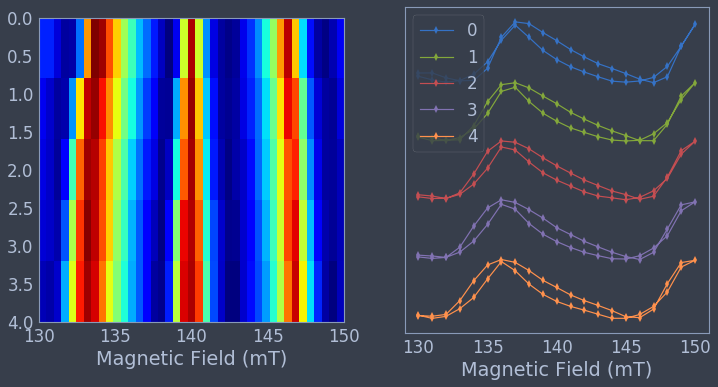

scancoord  kerr_rotation scan_type_2d scan_type_1d  \
index_2d index_1d                                                       
1.0      0             130.0       -0.02180      voltage   b_external   
         1             131.0       -0.02170      voltage   b_external   
         2             132.0       -0.02855      voltage   b_external   
         3             133.0       -0.03275      voltage   b_external   
         4             134.0       -0.03225      voltage   b_external   

                       lockin2x      lockin2r  lockin1r  voltage  laserpower  \
index_2d index_1d                                                              
1.0      0         1.106644e-02  1.112800e-33   0.02220      0.0       0.757   
         1         1.055400e-03  1.100774e-32   0.02185      0.0       0.759   
         2         1.128660e-02  1.199200e-03   0.02870      0.0       0.747   
         3         1.288000e-33  1.227740e-03   0.03285      0.0       0.759   
         4         1.100820e-32  1.133100e-32   0.03225      0.0       0.765   

                   cwetalon       laser_h  laser_v  temperature  file_index  \
index_2d index_1d                                                             
1.0      0           -0.145  3.940000e-11   0.0020       10.012           0   
         1           -0.152  3.100000e-22  -0.9559       10.000           0   
         2           -0.144  8.488000e-01   0.0000       10.001           0   
         3           -0.128  2.200000e-02  -0.0030        9.998           0   
         4           -0.160  2.200000e-02  -0.0100        9.999           0   

                   wavelength  
index_2d index_1d              
1.0      0              818.6  
         1              818.6  
         2              818.6  
         3              818.6  
         4              818.6

In [56]:
# TAKE A LOOK AT ANY RUN INDIVIDUALLY
run_index = 9
valid_run_ids = full_dataframe.index.get_level_values('run_id').unique()
print("Run {} of valid IDs: {}".format(run_index, list(valid_run_ids)))
assert run_index in valid_run_ids
run_dataframe = full_dataframe.xs(run_index, level='run_id')

print('---')
print('metadata of first file in run:')
file_index = run_dataframe['file_index'].values[0]
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
print('---')


# OPTIONAL: screw around with it
# run_dataframe = run_dataframe.loc[run_dataframe['scancoord'] <= 0]

figure_size = (12, 6)
num_waterfall_plots = 9
data_column = 'kerr_rotation'
x_values_column = 'scancoord'
# y_values_column = run_dataframe['scan_type_2d'].values[0]  # useful if works
y_values_column = None
xlabel = "Magnetic Field (mT)"
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(run_dataframe, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(run_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None,
                                ax=ax2, add_legend=True)
ax2.yaxis.set_ticklabels([])

# OPTIONAL: tinkering again
# ax1.xaxis.set_ticklabels([130, 140, 150, 140, 130])

plt.show()
run_dataframe.head()  # view first 5 rows
# run_dataframe.groupby(level=-2).head(1)  # view 1st row of each 2d index

Key: Value
SecondScanType: Voltage
Wavelength (nm): 818.6
SecondScanIndex: 2.0
SecondScanCoord: 0.0
Acquisition Program: GeneralScanner
Run ID: 10
Set Temperature (K): 10.0
Voltage: 0.0
Filepath: C:\Data\feb2017_data_part2\170217\RSA_FieldScanTesting_From+300mT_Increasing_Narrow_Jumped100mTto300mTx4_-160ps___818.60nm_10K_2Dscan_Voltage_BExternal\Ind_2_BExternal 0.13_to_0.13 Voltage 0x.dat
Delay Time (ps): -160.0
File Last Modified: Fri Feb 17 16:54:11 2017
FirstScanType: BExternal


scancoord  kerr_rotation scan_type_2d scan_type_1d  \
run_id index_2d index_1d                                                       
10     2.0      0             130.0       -0.03275      voltage   b_external   
                1             131.0       -0.02975      voltage   b_external   
                2             132.0       -0.01100      voltage   b_external   
                3             133.0        0.02135      voltage   b_external   
                4             134.0        0.04520      voltage   b_external   

                              lockin2x      lockin2r  lockin1r  voltage  \
run_id index_2d index_1d                                                  
10     2.0      0         1.009980e-33  1.112000e-03   0.03265      0.0   
                1         1.228000e-03  9.866000e-44   0.02965      0.0   
                2         7.800000e-44  7.794000e-03   0.01030      0.0   
                3         5.080000e-04  4.940000e-04   0.02225      0.0   
                4         2.274000e-03  3.380000e-03   0.04555      0.0   

                          laserpower  cwetalon       laser_h       laser_v  \
run_id index_2d index_1d                                                     
10     2.0      0              0.755    -0.156  9.909000e+00  0.000000e+00   
                1              0.761    -0.140  0.000000e+00  1.100000e-02   
                2              0.763    -0.152  9.911000e+00 -9.020000e-11   
                3              0.775    -0.132  9.299000e-11  2.200000e-02   
                4              0.767    -0.158  9.110000e-11  0.000000e+00   

                          temperature  file_index  wavelength  
run_id index_2d index_1d                                       
10     2.0      0              10.004          10       818.6  
                1              10.010          10       818.6  
                2              10.003          10       818.6  
                3               9.990          10       818.6  
                4               9.994          10       818.6

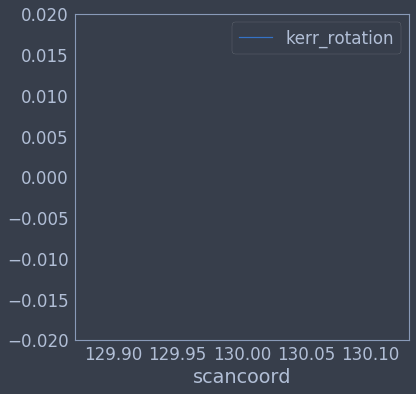

In [57]:
# TAKE A LOOK AT ANY SUBFILE
# tip: if you want to look at a specific run,
#      pick out a file_index from run-plotting cell
file_index = 10
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[file_index].plot(x='scancoord', y='kerr_rotation', ylim=[-0.02, 0.02])
file_dataframes_list[file_index].head()

In [58]:
# # EXAMPLE - REORDERING AXES
# df = full_dataframe
# df = df.groupby(level=[-3, -2]).head(5)
# new_index = df.index.reorder_levels([-2, -3, -1])
# df.index = new_index
# df

## Pandas-lmfit helper functions

In [59]:
# simulation importation
# from experimentdataanalysis.simulations.simple_dnp_trkr_rsa_simulation \
#     import ???

# perhaps needed:
# extracting df data into easy numpy ndarrays
from experimentdataanalysis.analysis.dataframe_processing \
    import df_extract_dataset_indexed_matrices, \
           df_extract_vector_lists_by_dataset

# df_extract_dataset_indexed_matrices(df, column_names)
# df_extract_vector_lists_by_dataset(df, column_names)

# generally useful global constants:
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

In [142]:
# IN-NOTEBOOK SIMULATION
from experimentdataanalysis.simulations.simple_trkr_rsa_simulation \
    import get_pulse_sum_vector, \
           trkr_decaying_cosine

# function defs for reference
# get_pulse_sum_vector(bfield, spin_lifetime, gfactor, initial_phase=0)
# trkr_decaying_cosine(delay_time, total_bfield,
#                      pulse_amplitude,
#                      gfactor, spin_lifetime,
#                      initial_phase, extra_phase_offset,
#                      slope, offset)

def dummy_dnp_update(local_spin_state, time_elapsed,
                     b_external, pump_power, laser_wavelength):
    old_dnp_field = local_spin_state.dnp_field
    new_dnp_field = old_dnp_field
    return new_dnp_field

def setpoint_dnp_update(local_spin_state, time_elapsed,
                        b_external, pump_power, laser_wavelength):
    if b_external == 0.0:
        return 0.0
    dnp_target_coeff = 4.0
    time_const = 20.0  # seconds, towards set point
    old_dnp_field = local_spin_state.dnp_field
    total_b = b_external + old_dnp_field
    e_spin_amplitude, _ = \
        local_spin_state.get_pulse_sum_vector(total_b)
    target_dnp_field = dnp_target_coeff * e_spin_amplitude
    old_dnp_gap = target_dnp_field - old_dnp_field
    new_dnp_gap = old_dnp_gap * np.exp(-time_elapsed / time_const)
    new_dnp_field = target_dnp_field - new_dnp_gap
    return new_dnp_field

class LocalSpinState():
    def __init__(self, gfactor, spin_lifetime, dnp_update_function):
        # dnp_update_function:
        #   LocalSpinState(), time_elapsed,
        #   b_external, pump_power, laser_wavelength -> new_dnp_field
        self.gfactor = gfactor
        self.spin_lifetime = spin_lifetime
        self.dnp_update_function = dnp_update_function
        self.dnp_field = 0.0

    def get_pulse_sum_vector(self, b_external):
        return get_pulse_sum_vector(b_external,
                                    self.spin_lifetime,
                                    self.gfactor)

    def get_kerr_rotation(self, probe_delay, b_external,
                          laser_wavelength=None):
        kerr_rotation = \
            trkr_decaying_cosine(
                probe_delay,
                self.dnp_field + b_external,
                pulse_amplitude=1.0,
                gfactor=self.gfactor,
                spin_lifetime=self.spin_lifetime,
                initial_phase=0, extra_phase_offset=0,
                slope=0, offset=0)
        return kerr_rotation

    def elapse_time(self, time_elapsed, b_external,
                    kerr_probe_delay=-160,
                    pump_power=1.0, laser_wavelength=None,
                    time_step=0.1):
        # NOTE: times are LAB times, in seconds
        tvals = np.r_[0.0:time_elapsed:time_step, time_elapsed]
        dnpvals = np.zeros_like(tvals)
        kerrvals = np.zeros_like(tvals)
        for ind, t in enumerate(tvals):
            if ind != 0:
                self.dnp_field = \
                    self.dnp_update_function(
                        local_spin_state=self,
                        time_elapsed=time_step,
                        b_external=b_external,
                        pump_power=pump_power,
                        laser_wavelength=laser_wavelength)
            dnpvals[ind] = self.dnp_field
            kerrvals[ind] = \
                self.get_kerr_rotation(kerr_probe_delay,
                                       b_external + self.dnp_field,
                                       laser_wavelength)
#                 self.get_pulse_sum_vector(b_external + self.dnp_field)[0]
        return tvals, dnpvals, kerrvals

def run_simulation_rsa(lab_time_vec, b_external_vec,
                       probe_delay,
                       gfactor=0.39,  # <- rest are simulation params
                       spin_lifetime=20000.0,
                       dnp_update_function=setpoint_dnp_update):
    state = LocalSpinState(gfactor, spin_lifetime,
                           dnp_update_function)
    elapsed_times = np.diff(lab_time_vec)
    tvals = lab_time_vec[0:1]
    bvals = b_external_vec[0:1]
    dnpvals = np.array([state.dnp_field])
    kerrvals = state.get_kerr_rotation(probe_delay, bvals)
    for t, dt, b_ext in zip(lab_time_vec[1:],
                            elapsed_times,
                            b_external_vec[1:]):
        new_dtvals, new_dnpvals, new_kerrvals = \
            state.elapse_time(time_elapsed=dt,
                              b_external=b_ext,
                              kerr_probe_delay=probe_delay)
        new_bvals = b_ext * np.ones_like(new_dtvals)
        tvals = np.concatenate([tvals, t - dt + new_dtvals])
        bvals = np.concatenate([bvals, new_bvals])
        dnpvals = np.concatenate([dnpvals, new_dnpvals])
        kerrvals = np.concatenate([kerrvals, new_kerrvals])
    return tvals, bvals, dnpvals, kerrvals

def run_simulation_2d(probe_delay_vec, b_external_vec,
                      time_elapsed_delay_scans,
                      pause_before_delay_scans,
                      gfactor=0.39,  # <- rest are simulation params
                      spin_lifetime=20000.0,
                      dnp_update_function=setpoint_dnp_update):
    state = LocalSpinState(gfactor, spin_lifetime,
                           dnp_update_function)
    probe_delay_vec = np.array(probe_delay_vec, copy=True)
    b_external_vec = np.array(b_external_vec, copy=True)
    start = pause_before_delay_scans
    stop = start + time_elapsed_delay_scans
    nstepsj = probe_delay_vec.size * 1j
    delay_scan_elapsed_time_vec = np.r_[start:stop:nstepsj]
    lab_time_grid = np.concatenate(
        [stop * ind + delay_scan_elapsed_time_vec
         for ind in range(len(b_external_vec))])
    delay_time_grid, b_external_grid = \
        np.meshgrid(probe_delay_vec, b_external_vec)
    dnp_grid = np.zeros_like(lab_time_grid)
    kerr_grid = np.zeros_like(lab_time_grid)
#     dnpvals = np.array([state.dnp_field])
#     kerrvals = state.get_kerr_rotation(probe_delay, bvals)
    for t, dt, b_ext in zip(lab_time_vec[1:],
                            elapsed_times,
                            b_external_vec[1:]):
        new_dtvals, new_dnpvals, new_kerrvals = \
            state.elapse_time(time_elapsed=dt,
                              b_external=b_ext,
                              kerr_probe_delay=probe_delay)
        new_bvals = b_ext * np.ones_like(new_dtvals)
        tvals = np.concatenate([tvals, t - dt + new_dtvals])
        bvals = np.concatenate([bvals, new_bvals])
        dnpvals = np.concatenate([dnpvals, new_dnpvals])
        kerrvals = np.concatenate([kerrvals, new_kerrvals])
    return tvals, bvals, dnpvals, kerrvals

def plot_b_dnp_kerr_vs_t(tvals, bvals,
                         dnpvals, kerrvals):
    plt.figure(figsize=(12, 8))
    plt.subplot(3,1,1)
    plt.plot(tvals, bvals, label='ext. b-field')
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(tvals, kerrvals, label='kerr rot.')
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(tvals, dnpvals, label='dnp b-field')
    plt.legend()
    plt.xlabel('Lab time (s)')

def plot_dnp_kerr_vs_b_delay(tvals, bvals,
                             dnpvals, kerrvals):
    pass


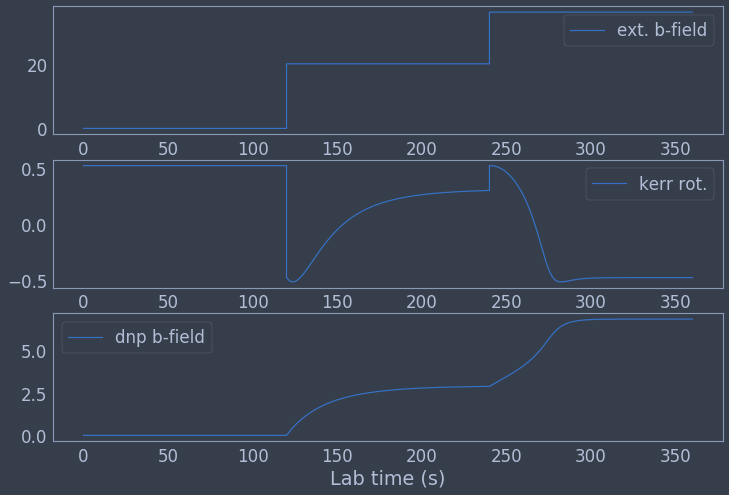

In [143]:
# simulation test code
probe_delay = -10
gfactor = 0.39
spin_lifetime = 20000.0
dnp_update_function = setpoint_dnp_update

b_external_vec = np.array([0, 0, 20, 36])
lab_time_vec = np.linspace(0, 360, len(b_external_vec))
tvals, bvals, dnpvals, kerrvals = \
    run_simulation_rsa(lab_time_vec, b_external_vec,
                       probe_delay,
                       gfactor, spin_lifetime,
                       dnp_update_function)
plot_b_dnp_kerr_vs_t(tvals, bvals, dnpvals, kerrvals)

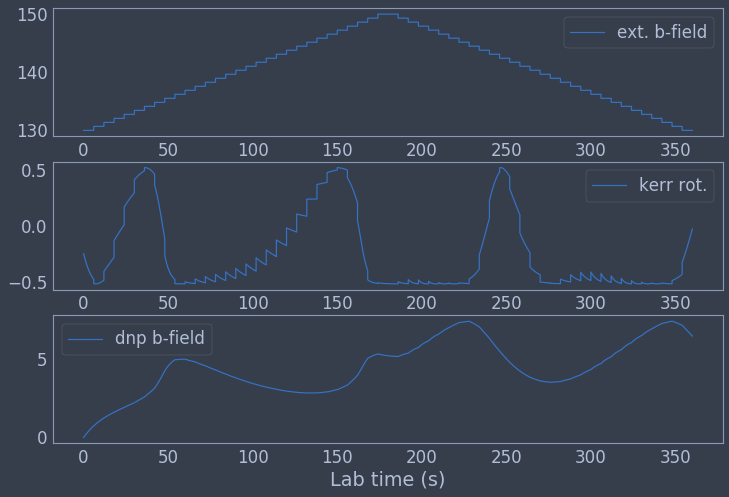

In [144]:
# simulation test code
probe_delay = -10
gfactor = 0.39
spin_lifetime = 20000.0
dnp_update_function = setpoint_dnp_update

vec_len = 60  # must be multiple of 2
lab_time_vec = np.linspace(0, 360, vec_len + 1)
b_external_vec = np.r_[130,
                       130:150:(vec_len/2*1j),
                       150:130:(vec_len/2*1j)]
tvals, bvals, dnpvals, kerrvals = \
    run_simulation_rsa(lab_time_vec, b_external_vec,
                       probe_delay,
                       gfactor, spin_lifetime,
                       dnp_update_function)
plot_b_dnp_kerr_vs_t(tvals, bvals, dnpvals, kerrvals)

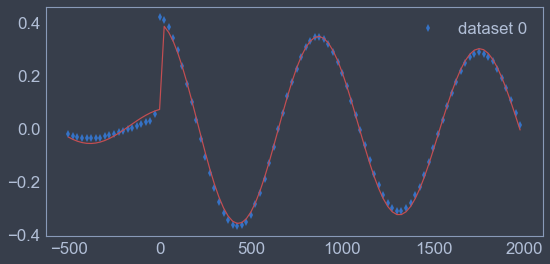

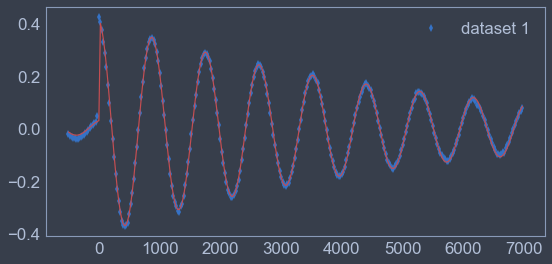

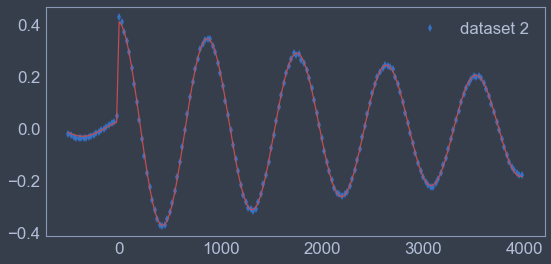

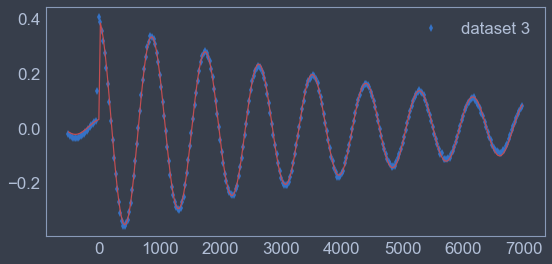

In [42]:
# PLOT SIMULATION RESULTS VS ACTUAL DATA
result_indices_to_plot = [0, 1, 2, 3]
for result_index in result_indices_to_plot:
    dataset_index_2d = np.int(results_df.index[result_index])
    result = minimize_results[dataset_index_2d]
    xvals = df.loc[dataset_index_2d].probe_delay
    yvals = df.loc[dataset_index_2d].lockin2
    fit_yvals = residuals_fcn(result.params,
                              df.loc[dataset_index_2d].probe_delay,
                              df.loc[dataset_index_2d].b_external)
    plt.figure(figsize=(8,4))
    plt.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    plt.plot(xvals, fit_yvals, 'r')
    plt.legend()